# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [9]:
# Import the necessary packages
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from maddpg_agent import MADDPG

def maddpg_train(maddpg, n_episodes=1000, print_every=100, num_agents=2):
    """
    Params
    ======
        maddpg (): Multi-Agents 
        n_episodes (int): maximum number of training episodes
        print_every (int): episodes interval to print training scores
        num_agents (int): the number of parallel agents
    """
    scores_deque = deque(maxlen=print_every)
    scores = []
    # amplitude of OU noise, this slowly decreases to 0
    noise = 2.0
    noise_reduction = 0.99999
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]                      # reset the environment    
        states = env_info.vector_observations                                  # get the current state
        scores_i = np.zeros(num_agents)                   
        
        maddpg.reset()
        while True:
            # get experiences (for each agent)
            actions = maddpg.act(states, noise, preprocess=True)                # select actions
            env_info = env.step(actions)[brain_name]                            # send all actions to the environment
            next_states = env_info.vector_observations                          # get next states
            rewards = env_info.rewards                                          # get reward
            dones = env_info.local_done                                         # see if episode finished
            # store experience & train multi-agents
            maddpg.step(states, actions, rewards, next_states, dones)
            # update for the next step
            scores_i += env_info.rewards                                        # update the score
            states = next_states                                                # roll over states to next time step
            noise *= noise_reduction                                            # reduce noise
            if np.any(dones):                                                   # exit loop if episode finished
                break
                
        maddpg.save_model()                                    # save the latest model after each episode
                
        # save average of the most recent average scores and model weights
        scores_deque.append(max(scores_i))             
        scores.append(max(scores_i))
        
        # display training progress
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            noise *= noise_reduction 
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.51:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
    print('TRAINING OVER.')        
    return scores

agents = MADDPG(state_size, action_size, 
                 random_seed=1, gamma=0.95, tau=1e-3,               
                 buffer_size=int(1e5), batch_size=128,  
                 lr_actor=1e-4, lr_critic=1e-3, weight_decay=0,
                 num_agents=2)

In [12]:
N_EPISODES = 2500
PRINT_EVERY = 100
# apply MADDPG to train 'Tennis' environment
scores = maddpg_train(maddpg=agents, n_episodes=N_EPISODES, print_every=PRINT_EVERY, num_agents=2)

Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.01
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.02
Episode 800	Average Score: 0.01
Episode 900	Average Score: 0.01
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.01
Episode 1200	Average Score: 0.01
Episode 1300	Average Score: 0.02
Episode 1400	Average Score: 0.01
Episode 1500	Average Score: 0.02
Episode 1600	Average Score: 0.01
Episode 1700	Average Score: 0.01
Episode 1800	Average Score: 0.01
Episode 1900	Average Score: 0.01
Episode 2000	Average Score: 0.02
Episode 2100	Average Score: 0.01
Episode 2200	Average Score: 0.02
Episode 2300	Average Score: 0.02
Episode 2400	Average Score: 0.01
Episode 2500	Average Score: 0.01
TRAINING OVER.


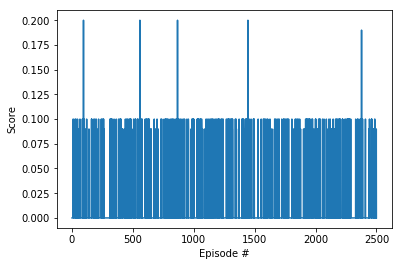

In [13]:
# plot training results
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('./readme_imgs/maddpg_train.png')

In [14]:
env.close()